<a href="https://colab.research.google.com/github/ashfarhangi/Livid-About-COVID/blob/master/SIRNET_Notebook_Working.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/Nu-AI/Livid-About-COVID.git

Cloning into 'Livid-About-COVID'...
remote: Enumerating objects: 286, done.
remote: Counting objects: 100% (286/286), done.
remote: Compressing objects: 100% (126/126), done.
remote: Total 1139 (delta 185), reused 242 (delta 156), pack-reused 853
Receiving objects: 100% (1139/1139), 15.00 MiB | 13.28 MiB/s, done.
Resolving deltas: 100% (707/707), done.


In [2]:
!pip install -r  /content/Livid-About-COVID/requirements.txt

     |████████████████████████████████| 516.2MB 29kB/s 
ERROR: Could not find a version that satisfies the requirement torch~=1.4.1 (from -r /content/Livid-About-COVID/requirements.txt (line 6)) (from versions: 0.1.2, 0.1.2.post1, 0.1.2.post2, 0.3.1, 0.4.0, 0.4.1, 1.0.0, 1.0.1, 1.0.1.post2, 1.1.0, 1.2.0, 1.3.0, 1.3.1, 1.4.0, 1.5.0, 1.5.1)
ERROR: No matching distribution found for torch~=1.4.1 (from -r /content/Livid-About-COVID/requirements.txt (line 6))


In [ ]:
!python /content/Livid-About-COVID/scripts/fit_bexar.py

Bexar County
146
['Texas', 'Anderson County', 'Andrews County', 'Angelina County', 'Aransas County', 'Archer County', 'Armstrong County', 'Atascosa County', 'Austin County', 'Bailey County', 'Bandera County', 'Bastrop County', 'Baylor County', 'Bee County', 'Bell County', 'Bexar County', 'Blanco County', 'Borden County', 'Bosque County', 'Bowie County', 'Brazoria County', 'Brazos County', 'Brewster County', 'Briscoe County', 'Brooks County', 'Brown County', 'Burleson County', 'Burnet County', 'Caldwell County', 'Calhoun County', 'Callahan County', 'Cameron County', 'Camp County', 'Carson County', 'Cass County', 'Castro County', 'Chambers County', 'Cherokee County', 'Childress County', 'Clay County', 'Cochran County', 'Coke County', 'Coleman County', 'Collin County', 'Collingsworth County', 'Colorado County', 'Comal County', 'Comanche County', 'Concho County', 'Cooke County', 'Coryell County', 'Cottle County', 'Crane County', 'Crockett County', 'Crosby County', 'Culberson County', 'Dall

In [13]:
from abc import ABC, abstractmethod

import torch
from torch.nn.parameter import Parameter


class SIRNetBase(ABC, torch.nn.Module):
    # Subclasses must set this. For SIR, the 3 compartments would be S, I, R...
    N_MOBILITY = 6
    N_COMPARTMENTS = 3
    N_OUTPUTS = 1

    def __init__(self, input_size=6, hidden_size=3, output_size=1, i0=5.6e-6,
                 k=0.2, b_model='linear', update_k=False, b_kwargs=None):
        # TODO(document): b_kwargs are passed to _make_b_model and are not
        #  standard **kwargs as those may be used for other attributes or
        #  sub-models
        super(SIRNetBase, self).__init__()

        # Number of mobility points
        # TODO: this should be able to be reduced at least
        assert input_size == self.N_MOBILITY, \
            'Input dimension must be %d' % self.N_MOBILITY
        # Number of compartments of the SIR-like model
        assert hidden_size == self.N_COMPARTMENTS, \
            'Hidden dimension must be %d' % self.N_COMPARTMENTS
        # Number of cases or other outputs
        assert output_size == self.N_OUTPUTS, \
            'Output dimension must be %d' % self.N_OUTPUTS
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        # gamma=.2 : 5 day (3-7 day) average duration of infection [Woelfel
        # et al]
        self.k = Parameter(torch.tensor([[k]], dtype=torch.float32),
                           requires_grad=update_k)
        # b
        self.b_model = b_model.lower()
        self._make_b_model(**(b_kwargs or {}))
        # i0 - infected init @ time 0 (no gradient)
        self.i0 = Parameter(torch.tensor(i0, dtype=torch.float32),
                            requires_grad=False)

    def _make_b_model(self, lstm_hidden_size=None, lstm_bias=False):
        """Transforms input to b parameter of SIR-like models"""
        if self.b_model == 'linear':
            # Initialization from prior training
            b_init = torch.tensor(
                [[7.3690e-02, 1.0000e-04, 1.0000e-04, 6.5169e-02, 1.4331e-01,
                  2.9631e-03]], dtype=torch.float32
            )
            self.i2b = torch.nn.Linear(self.input_size, 1, bias=False)
            self.i2b.weight.data = b_init
        elif self.b_model == 'lstm':
            if lstm_hidden_size is None:
                lstm_hidden_size = self.N_MOBILITY  # good default
            self.i2l = torch.nn.LSTM(self.input_size, lstm_hidden_size,
                                     bias=lstm_bias)
            self.l2b = torch.nn.Linear(lstm_hidden_size, 1)
        else:
            raise ValueError('b_model must be either "linear" or "lstm" but '
                             'received: {}'.format(self.b_model))

    @abstractmethod
    def _forward_init(self, hidden):
        """Subclasses must implement this to properly initialize hidden and call
        this via super() to initialize the b_model properly"""
        if self.b_model == 'lstm':
            # LSTM states
            self.h_t = torch.zeros(1, 1, self.i2b.hidden_size)
            self.c_t = torch.zeros(1, 1, self.i2b.hidden_size)

    def _forward_b(self, xt):
        """Contact rate as a function of our input vector"""
        if self.b_model == 'lstm':
            b_inter, (self.h_t, self.c_t) = self.i2l(
                xt[None, ...], (self.h_t, self.c_t)).squeeze(dim=1)
            # TODO No negative contact rates...pytorch does not have LSTM
            #  option to change tanh to relu this is dumb and needs fixing
            #  here for valid b that also trains well...need custom LSTM
            #  implementation in Python to change activation function
            b = torch.relu(self.l2b(b_inter)).squeeze()
        elif self.b_model == 'linear':
            # 2.2 should be value of b under normal mobility [Kucharski et al]
            # Remove residential mobility
            # TODO: Not right spot for this. Disambiguate residential mobility..
            xm = xt.clone()
            xm[0, 5] = 0
            # log of the contact rate as linear combination of mobility squared
            # b = torch.clamp(torch.exp(-self.i2b(xm)), 0)
            # Just look at norm of mobility- this is actually very good/
            # maybe more reliable.
            b = self.q * torch.norm(xm) ** self.p
            # b = torch.relu(self.i2b(xm)) ** self.p  # Best method so far
        else:
            raise RuntimeError('b_model is invalid, this should not have '
                               'happened')  # earlier check in _make_b_model()
        return b

    @abstractmethod
    def _forward_update_state(self, hidden, prev_h, b, *args, **kwargs):
        """Update the SIR-like state of the model. Subclasses must implement
        this. Subclasses should return an updated version of `hidden`"""
        raise NotImplementedError

    def _forward_output(self, hidden):
        """It may be a good idea to update this in subclasses, and necessarily
        must do so is the order of the SIR-like compartments does NOT begin with
        I, R"""
        return (hidden[:, 0] + hidden[:, 1])[..., None]  # add dimension w/ None

    def _forward_cleanup(self):
        if self.b_model == 'lstm':
            # Remove LSTM state storage
            del self.h_t
            del self.c_t

    def forward(self, X):
        time_steps = X.size(0)  # time first
        batch_size = X.size(1)  # batch second
        hidden = torch.zeros(
            batch_size, self.hidden_size
        ).to(device=X.device)  # hidden state is i,r,s,...
        # Initialize for the forward pass
        self._forward_init(hidden)
        # TODO: include init hidden in output hiddens?
        prev_h = hidden.clone()  # init previous state
        hiddens = []
        outputs = []
        for t in range(time_steps):
            # compute b
            b = self._forward_b(X[t])
            # update the hidden state of SIR-like model
            hidden = self._forward_update_state(hidden, prev_h, b)
            # update the outputs
            prev_h = hidden.clone()
            outputs.append(self._forward_output(prev_h))
            hiddens.append(prev_h)
        # End of loop cleanup
        self._forward_cleanup()

        return torch.stack(hiddens), torch.stack(outputs)


class SIRNet(SIRNetBase):
    N_COMPARTMENTS = 3
    N_OUTPUTS = 1

    def _forward_init(self, hidden):
        hidden[:, 0] = self.i0
        hidden[:, 2] = 1.0 - self.i0
        super()._forward_init(hidden)

    def _forward_update_state(self, hidden, prev_h, b):
        # update the hidden state SIR model @formatter:off
        drdt = self.k * prev_h[:, 0]
        hidden[:, 0] = prev_h[:, 0] + prev_h[:, 0] * b * prev_h[:, 2] - drdt  # infected
        hidden[:, 1] = prev_h[:, 1] + drdt                                    # recovered
        hidden[:, 2] = 1.0 - prev_h[:, 0] - prev_h[:, 1]                      # susceptible
        # @formatter:on
        return hidden


class SEIRNet(SIRNetBase):
    N_COMPARTMENTS = 4
    N_OUTPUTS = 1

    def __init__(self, *args, hidden_size=4, e0=5.6e-6, update_s=False,
                 **kwargs):
        super(SEIRNet, self).__init__(*args, hidden_size=hidden_size, **kwargs)

        # sigma - 5 day incubation period [Backer et al]
        self.s = Parameter(torch.tensor([[.20]], dtype=torch.float32),
                           requires_grad=update_s)
        self.p = Parameter(torch.tensor([[2.5]], dtype=torch.float32),
                           requires_grad=True)
        self.q = Parameter(torch.tensor([[0.2]], dtype=torch.float32),
                           requires_grad=True)
        # Exposed init @ time 0 (no gradient)
        self.e0 = Parameter(torch.tensor(e0, dtype=torch.float32),
                            requires_grad=False)

    def _forward_init(self, hidden):
        hidden[:, 0] = self.i0  # initial infected
        hidden[:, 2] = 1.0 - self.i0 - self.e0  # susceptible
        hidden[:, 3] = self.e0  # initial exposed
        super()._forward_init(hidden)

    def _forward_update_state(self, hidden, prev_h, b):
        # update the hidden state SIR model (states are I R S E)
        # @formatter:off
        d1 = self.k * prev_h[:, 0]             # gamma * I  (infected people recovering)
        d2 = prev_h[:, 0] * b * prev_h[:, 2]   # b * s * i  (susceptible people becoming exposed)
        d3 = self.s * prev_h[:, 3]             # sigma * e  (exposed people becoming infected)

        hidden[:, 3] = prev_h[:, 3] + d2 - d3  # exposed = exposed + contact_rate * susceptible * infected - sigma * e
        hidden[:, 0] = prev_h[:, 0] + d3 - d1  # infected = infected + s * exposed - infected*recovery_rate
        hidden[:, 1] = prev_h[:, 1] + d1       # recovered = recovered + infected*recovery_rate
        hidden[:, 2] = prev_h[:, 2] - d2       # susceptible
        # @formatter:on
        # TODO: this won't sum up correctly, should we min-max normalize
        #  instead?
        return torch.clamp(hidden, 0, 1)  # all states must be positive


In [14]:
"""
Trainer class usage:

```
trainer = Trainer(weights_path)
model = trainer.build_model(e0, i0)
trainer.train(model, X, Y, iters)
```
"""
import os
import math

import torch

# from .sirnet import SEIRNet


class Trainer(object):
    def __init__(self, weights_path):
        # check if weights path exists
        self.weights_path = weights_path

    def build_model(self, e0, i0, b_model='linear', update_k=False):
        # Sequential model
        model = torch.nn.Sequential()
        model.add_module('SEIRNet', SEIRNet(e0=e0, i0=i0, b_model=b_model,
                                            update_k=update_k))
        if os.path.exists(self.weights_path):
            model.load_state_dict(torch.load(self.weights_path))
        return model

    def iteration(self, model, loss, optimizer, x, y, log_loss=True):
        optimizer.zero_grad()

        hx, fx = model.forward(x)

        if log_loss:
            output = loss.forward(torch.log(fx), torch.log(y))
        else:
            output = loss.forward(fx, y)
        output.backward()
        optimizer.step()
        # for name, param in model.named_parameters():
        #  if name == "SEIRNet.i2b.weight":
        #     param.data.clamp_(1e-2)
        return output.data.item()

    def train(self, model, X, Y, iters, step_size=4000):
        # Optimizer, scheduler, loss
        loss = torch.nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                    step_size=step_size,
                                                    gamma=0.1)
        torch.autograd.set_detect_anomaly(True)

        for i in range(iters):
            iterator = zip([X], [Y])
            for X, Y in iterator:
                batch_size = Y.shape[0]
                cost = 0.
                num_batches = math.ceil(len(X) / batch_size)
                for k in range(num_batches):
                    start, end = k * batch_size, (k + 1) * batch_size
                    cost += self.iteration(model, loss, optimizer, X[start:end],
                                           Y[start:end])
                if (i + 1) % 50 == 0:
                    print('\nEpoch = %d, cost = %s' %
                          (i + 1, cost / num_batches))
                    print('The model fit is: ')
                    for name, param in model.named_parameters():
                        print(name, param.data)
            # TODO: scheduler may restart learning rate if trying to load from
            #  file. Mitigation: store epoch number in filename
            scheduler.step()
        torch.save(model.state_dict(), self.weights_path)
        return cost  # the final cost


In [15]:
import warnings

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# ==============================
# =           Util           =
# ==============================



def to_numpy(tensor, squeeze=True):
    """Converts a PyTorch Tensor to a NumPy array.

    :param tensor: A PyTorch tensor object (note this still works for Variables
        which are deprecated)
    :param squeeze: Whether to squeeze tensor (default: True)
    :return: PyTorch tensor as a NumPy array
    """
    if isinstance(tensor, np.ndarray):
        warnings.warn('to_numpy was passed tensor, but it is already a NumPy '
                      'ndarray. Continuing..')
        t_npy = tensor
    else:
        t_npy = tensor.cpu().detach().numpy()
    if squeeze:
        t_npy = np.squeeze(t_npy)
    return t_npy


def plot_sir_state(sir_state, title='SIR_state', show=True):
    # Plot the SIR state
    plt.plot(sir_state)
    legend_labels = ['I', 'R', 'S']
    if sir_state.shape[1] == 4:
        legend_labels.append('E')
    elif sir_state.shape[1] != 3:
        warnings.warn('plot_sir_state received `sir_state` with unexpected '
                      'shape {} (dim 1 not 3 or 4). Assuming SIR and using the '
                      'legend labels: {}'.format(sir_state.shape,
                                                 legend_labels))
    plt.legend(legend_labels)
    plt.xlabel('Day')
    plt.ylabel('Value')
    if title is not None:
        plt.title(title)
    if show:
        plt.show()


def plt_setup():
    # Default text size
    plt.rcParams.update({'font.size': 22})
    plt.grid(True)
    plt.legend()
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=30))
    plt.gcf().autofmt_xdate()


In [19]:
import pandas as pd
import urllib.request
import click
import numpy as np
import warnings
# ==============================
# =           Data Reterieve           =
# ==============================



warnings.filterwarnings("ignore")
## Steps to do ---
# Input will be county name and state name
# If all counties are required we take in all as the input
# Gather the mobility data
# Gather the pop data from the pop files ( create a lookup table for that first)
# Gather the county names and active cases data
# Gather the intervention data if the country selected is USA

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', -1)

# Setting the parameters for the data required.
# If require data for only country or states, then set counties to None
defaultParams={
    'country': 'United States',         # Can be only one country
    'states' : ['Texas'],               # Can enter either one or multiple states
    'counties' : ['all'] # Can enter multiple or one county. If all counties are required, fill in ['all']
}

class data_retriever():

    def __init__(self, country, states=None, counties = None ):
        self.states = states
        self.country = country
        self.counties = counties


    # Method to align the length of table for the mobility data to match the length of case data

    def fill_missing_days_df(self, df_required):
        end_date = pd.to_datetime(df_required['date'][df_required.index[-1]])
        # Fill in the missing days in the mobility data
        start_date = pd.to_datetime((df_required['date'][df_required.index[0]]))
        total_no_days = int(str(end_date - start_date).split(" ")[0])
        actual_days_list = list(pd.to_datetime(np.arange(1, total_no_days + 1, 1), unit='D',
                                               origin=pd.Timestamp(df_required['date'][df_required.index[0]])).astype(str))
        days_list = list(df_required['date'].values)
        if (len(days_list)!= len(actual_days_list)):
            diff_list = [i for i in actual_days_list if i not in days_list]
        #df_required['date'] = actual_days_list
        counter = 0
        counter2 = 0
        new_df = pd.DataFrame(columns=df_required.columns)
        new_df['date'] = actual_days_list
        for day in actual_days_list:
            if day in days_list:
                new_df.iloc[counter] = df_required.iloc[counter]
                counter+=1
            else:
                new_df.iloc[counter+counter2] = pd.Series(np.NaN)
                counter2+=1
        return new_df


    def extend_required_df(self,df_required):

        keylist = ['country_region', 'sub_region_1', 'sub_region_2']
        state_cases_df = pd.read_csv(urllib.request.urlopen(
            "https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv"))
        date_list = state_cases_df['date'].unique().tolist()
        date2 = pd.to_datetime(date_list[-1])
        date1 = pd.to_datetime(df_required['date'][df_required.index[-1]])
        no_days = int((str(date2-date1)).split(" ")[0])

        county_list = list(df_required['sub_region_2'].values)
        unique_list = list(df_required['sub_region_2'].unique())
        counter = [county_list.count(i) for i in unique_list]
        temp = list(pd.to_datetime(np.arange(1, no_days + 1, 1), unit='D',
                                        origin=pd.Timestamp(df_required['date'][df_required.index[-1]])).astype(str))


        index = 0-no_days
        for i in range(no_days):
            df_required = df_required.append(pd.Series([np.NaN]), ignore_index=True)

        for i in range(no_days):
            df_required['date'][df_required.index[index]] = temp[i]
            index += 1

        for keys in df_required:
            #print(keys)
            if df_required[keys].nunique() == 1:
                if keys in keylist:
                    # print (keys, list(df_required[keys].unique())[0])
                    df_required[keys] = df_required[keys].fillna(list(df_required[keys].unique())[0])
        print (len(list(df_required['date'].values)))
        return df_required


    def apply_extension(self, df_required, region):
        new_df_list = []
        unique_list = df_required[region].unique().tolist()
        #print (len(unique_list), "The unique elements", unique_list)
        for county in unique_list:
            print (county)
            df = self.extend_required_df(df_required[df_required[region]==county])
            new_df_list.append(df)
        return pd.concat(new_df_list, sort=True)

    # Retrieves the mobility data for the respective counties or states or country
    def get_mobility_data(self):

        # Retrieve mobility data from Google's mobility reports.
        df = pd.read_csv(urllib.request.urlopen("https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv"), low_memory=False)
        # Lambda function to filter the required data from the global mobility data.
        filtering_func = lambda x,y: x.where(x['sub_region_2'].isin(y) == True).dropna().reset_index() if y== self.counties else \
                        x.where(x['sub_region_2'].isin(y) == True).dropna().reset_index()
        # Check if data is required for only the country
        if self.country is not None and self.states is None:
            df_country = df[df['country_region']==self.country].dropna(how='all').reset_index()
            # If want all the county data also
            if (self.counties is not None):
                if ('all' not in self.counties):
                    df_required = filtering_func(df_country, self.counties)
                    df_required = self.apply_extension(df_required,'sub_region_2')
            else:
                df_required = df_country.reset_index()
            return df_required

        else:
            # Get the state mobility data
            df_state = df.where(df['sub_region_1'].isin(self.states)==True).dropna(how='all').fillna('').reset_index()
            # The state total mobility
            if (self.counties is None):
                df_required = df_state[df_state['sub_region_2']==''].reset_index()
                df_required = self.apply_extension(df_required, 'sub_region_1')
             # All the county mobility in the state
            elif ('all' in self.counties):
                df_required = df_state[df_state['sub_region_2'] != ''].reset_index()
                #print (df_required.size, "The newer size", df_state.size)
                #print("obtained the df")
                df_required = self.apply_extension(df_required, 'sub_region_2')
                #print ("obtained the df")
            # Mobility data for given counties
            else:
                df_required = filtering_func(df_state, self.counties)
                df_required = self.apply_extension(df_required,'sub_region_2')
                #df_required = df_state.where(df_state['sub_region_2'].isin(self.counties)==True).dropna(how='all').reset_index()

            return df_required



    #Get the lookup table for getting population data
    @staticmethod
    def get_lookup_table():
        states = "Alabama Alaska Arizona Arkansas California Colorado Connecticut Delaware Florida Georgia Hawaii Idaho Illinois Indiana Iowa Kansas Kentucky Louisiana Maine Maryland Massachusetts Michigan Minnesota Mississippi Missouri Montana Nebraska Nevada New_Hampshire New_Jersey New_Mexico New_York North_Carolina North_Dakota Ohio Oklahoma Oregon Pennsylvania Rhode_Island South_Carolina South_Dakota Tennessee Texas Utah Vermont Virginia Washington West_Virginia Wisconsin Wyoming"
        states_list = states.split(" ")
        keys = "01 02 04 05 06 08 09 10 12 13 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 44 45 46 47 48 49 50 51 53 54 55 56"
        key_list = keys.split(" ")
        LUT ={}
        i = 0
        for states in states_list:
            LUT[states] = key_list[i]
            i+=1
        return LUT

    # Filter the required population data
    def get_population_data(self, df_required):

        LUT_dict = self.get_lookup_table()
        state_list = df_required['sub_region_1'].dropna().unique().tolist()

        state_list = ["_".join(state.split(" ")) for state in state_list]

        # retrieve the population data based on the state provided
        base_path = ["https://www2.census.gov/programs-surveys/popest/tables/2010-2019/counties/totals/co-est2019-annres-{}.xlsx".format(LUT_dict[state]) for state in state_list]

        state_list = [" ".join(state.split("_")) for state in state_list]

        i = 0
        final_pop_df = pd.DataFrame()
        # Iterate over the given paths for the states required
        count = 0
        for paths in base_path:
            # Can alternate between the below 2 lines if one is not working and
            # throws a hhtprequest exception
            # pop_df = pd.read_excel(urllib.request.urlopen(paths), skiprows=2,
            #                        skipfooter=5)
            pop_df = pd.read_excel(paths, skiprows=2, skipfooter=5)
            pop_df = pop_df[['Geographic Area', 'Unnamed: 12']].iloc[1:].reset_index()
            Area_list = pop_df['Geographic Area']
            area_list = [i.split(',')[0].replace('.', '') for i in Area_list]
            print (area_list,state_list)
            pop_df['Geographic Area'] = area_list
            get_state_arr = lambda state_list, pop_df :[state_list[count]] * len(pop_df['Geographic Area'].tolist())
            # Filter out the data required for the counties
            if (self.counties is not None):
                pop_df = pop_df.where(pop_df['Geographic Area'].isin(df_required[df_required['sub_region_1']==state_list[count]]\
                    ['sub_region_2'].unique())==True).dropna(how='all').reset_index()

                pop_df['State'] = get_state_arr(state_list, pop_df)

                count +=1
            # Just get the population for the required state
            else:
                pop_df = pop_df.where(pop_df['Geographic Area']==state_list[i]).dropna(how='all').reset_index()
                pop_df['State'] = get_state_arr(state_list, pop_df)
                count +=1
            final_pop_df = final_pop_df.append(pop_df,sort=True)
            i+=1

        return final_pop_df

    # Retrieve the temporal active cases and deaths information for counties
    def get_cases_data(self, df_required):

        state_cases_update = lambda state_cases_df : state_cases_df[state_cases_df['state'].isin(self.states) & (state_cases_df['date'].isin(df_required['date'].unique().tolist()))]

        # If require county level cases data
        if self.counties is not None:
            state_cases_df = pd.read_csv(urllib.request.urlopen(
                "https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv"))
            state_cases_df = state_cases_update(state_cases_df)

            # Special Case for New York City
            state_cases_df = state_cases_df.replace("New York City", "New York")
            state_cases_df.loc[state_cases_df["county"]=="New York", 'fips'] = 36061

            # temp_df = state_cases_df[state_cases_df["county"]=="New York"]
            # fip_list = state_cases_df.loc[state_cases_df["county"]=="New York"]['fips'].values.tolist()
            # new_fip_list = [36061]*len(fip_list)
            # temp_df['fips'] = new_fip_list
            # #state_cases_df[state_cases_df["county"]=="New York"]['fips'] = temp_df['fips']
            # #print (temp_df)
            # #state_cases_df.loc[state_cases_df["county"]=="New York"]['fips']].fillna(value=36061, inplace=True)

            unique_counties = state_cases_df['county'].unique().tolist()
            county_list = []
            for county in unique_counties:
                county_df = state_cases_df[state_cases_df['county']==county]
                county_name = county + " County"
                required_cdf = df_required[df_required['sub_region_2']==county_name]
                county_df = county_df[county_df['date'].isin(required_cdf['date'].unique().tolist())]
                county_list.append(county_df)
            state_cases_df = pd.concat(county_list,sort=True)
            #print (state_cases_df['county'].unique().tolist())
            # For all the counties in the state
            if 'all' in self.counties:
                county_cases_df = state_cases_df.sort_values(by = ['county','date']).reset_index()

            # For selected counties in the state
            else:
                new_counties = [" ".join(county.split(" ")[:-1]) for county in self.counties]
                #print (new_counties)
                county_cases_df = state_cases_df[state_cases_df['county'].isin(new_counties)].sort_values(by=['county','date'])

            county_cases_df=county_cases_df[['fips', 'date', 'county', 'state', 'cases', 'deaths']]
            print (county_cases_df['fips'].unique().tolist())
            #print (county_cases_df)
            #print(county_cases_df['date'])
            #print (county_cases_df.head(80))

            return self.reorganize_case_data(df_required,county_cases_df)

        # If require only state data
        else:
            state_cases_df = pd.read_csv(urllib.request.urlopen(
                "https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv"))
            state_cases_df = state_cases_update(state_cases_df)
            state_cases_df = state_cases_df[['date', 'state', 'cases', 'deaths']]
            return state_cases_df.sort_values(by=['state','date']).reset_index()

    # Reorganizing the data to match the mobility and population table

    def reorganize_case_data(self, df_required, df_county_cases):

        new_county_df = pd.DataFrame()
        new_temp_df = {}
        new_county_df_list = []
        #date_length =  len(df_required['date'].unique().tolist())
        county_list = df_required['sub_region_2'].unique()
        all_case_counties = []
        new_counties = []

        # Get the list of the counties provided when
        if (self.counties is not None):

            # All the counties are required
            if 'all' in self.counties:
                all_case_counties = list(df_county_cases['county'].unique())
                #print (all_case_counties)
                full_counties = list(df_required['sub_region_2'].unique())
                #print(full_counties)
                all_case_counties = [i + " County" for i in all_case_counties]
                if (len(all_case_counties) != len(full_counties)):
                    new_counties = full_counties
                else:
                    new_counties = all_case_counties
            # Specifically provided
            else:
                all_case_counties = self.counties
                new_counties = all_case_counties
        # Only for the state as a total
        else:
            new_counties = self.states

        # Obtain the case data for the counties or states
        county_list = list(df_required['sub_region_2'].values)
        #print(df_county_cases['fips'].unique().tolist())
        for county in new_counties:
            if self.counties is not None:
                # Check if the case data for counties required are present in the case dataframe

                if (county in all_case_counties):
                    temp_df = df_county_cases[df_county_cases['county']==' '.join(county.split(" ")[:-1])]
                    #print (temp_df, " ".join(county.split(" ")[:-1]))
                    county_name_list = list(temp_df['county'].values)
                    #print (county_name_list)
                    new_county_name_list = []
                    for val in county_name_list:
                        if "County" not in val:
                            new_val = val+" County"
                            new_county_name_list.append(new_val)
                    temp_df['county'] = new_county_name_list
                    #print (temp_df['fips'], " \n Condition 1", county)
                # Fill the ones with no case data with zeros
                else:
                    temp_df = df_required[df_required['sub_region_2']==county]
                    county_length = len(temp_df)
                    # Create a new dictionary with the required length
                    temp_df['cases'] = [0]*county_length
                    temp_df['deaths'] = [0]*county_length
                    temp_df['county'] = [county]*county_length
                    temp_df['fips'] = [0]*county_length
                    temp_df['state'] = temp_df['sub_region_1'].tolist()
                    temp_df = temp_df[['fips','date','county','state','cases','deaths']]
                    #print(temp_df['fips'], " \n Condition 2")
            # In the case of state data
            else:
                temp_df = df_county_cases[df_county_cases['state']==county.split(" ")[0]]

            length = county_list.count(county)
            # Extend the case list to map with the mobility and population data
            extend = lambda x,y: list(x[y].unique())*length
            # Create a dictionary for cases and deaths in the selected region
            #print (temp_df)
            case_list = list(temp_df['cases'].values)
            death_list = list(temp_df['deaths'].values)
            fips_list = list(temp_df['fips'].values)
            print (temp_df.keys(),"\n",fips_list)
            fips_val = fips_list[0]
            for _ in range(length-len(temp_df['cases'].tolist())):
                case_list.insert(0,0)
                death_list.insert(0,0)
                fips_list.insert(0,fips_val)

            if (len(temp_df['cases'].tolist())< length):
                #print ("Entered this condition")
                # Extend other columns in the table
                new_temp_df['state'] = df_required.loc[df_required['sub_region_2']==county]['sub_region_1'].tolist()
                if (self.counties is not None):
                    new_temp_df['county'] = df_required.loc[df_required['sub_region_2'] == county]['sub_region_2'].tolist()

                # Fill in the dictionary
                new_temp_df['fips'] = fips_list
                new_temp_df['date'] = df_required.loc[df_required['sub_region_2']==county]['date'].tolist()
                new_temp_df['cases'] = case_list
                new_temp_df['deaths'] = death_list

                new_county_df = pd.DataFrame.from_dict(new_temp_df)

                # Append the dataframes
                new_county_df_list.append(new_county_df)
            else:
                new_county_df_list.append(temp_df)

        return pd.concat(new_county_df_list,sort=True)



    # Get the intervention setting dates for the different counties and states in USA
    def get_intervention_data(self):

        df_data = pd.read_csv(urllib.request.urlopen(
            "https://github.com/Keystone-Strategy/covid19-intervention-data/raw/master/complete_npis_inherited_policies.csv")
            , sep = ',', error_bad_lines=False)

        # Filter the dataframe based on whether it is required for the counties or states
        if self.counties is not None:
            # Separate case in the case required for all the counties
            if 'all' not in self.counties:
                new_counties = [" ".join(county.split(" ")[:-1]) for county in self.counties]
                df_intervention = df_data[df_data['county'].isin(new_counties) & df_data['state'].isin(self.states)]
            else:
                df_intervention = df_data[df_data['state'].isin(self.states) & df_data['county'].isnull()==False]

        # Keep only the state intervention dates
        else:
            df_intervention = df_data[df_data['state'].isin(self.states) & df_data['county'].isnull()==True]

        #print(df_intervention.head(100))
        return df_intervention


# Combined function to form the final table with all the required data

def get_data(paramdict):

    # Initialize the data retriever class
    data = data_retriever(country=paramdict['country'], states = paramdict['states'], counties = paramdict['counties'])

    # Start with the mobility data
    df_required = data.get_mobility_data()
    #print(data.fill_missing_days_df(df_required[df_required['sub_region_2'] == 'Ferry County']))
    #print(df_required)
    # The below case exists because of lack of data integration for countries other than USA

    # # TODO incorporate population metrics for other countries
    if paramdict['country'] == 'United States' or paramdict['country'] is None:

        # Get the poppulation data
        pop_df = data.get_population_data(df_required)
        pop_df = pop_df.reset_index(drop=True)

        # Decimate non required columns
        pop_df = pop_df[['State', 'Geographic Area', 'Unnamed: 12']]
        county_list = pop_df.values.tolist()

        # Rename the columns to proper distribution
        pop_df.rename(columns={
            'State' : 'State',
            'Geographic Area' : 'County',
            'Unnamed: 12': 'Population'
        }, inplace=True)
        pop_list = pop_df['Population'].tolist()

        # Create an updated population list to account for the variability in sizes of mobility data
        county_list = list(df_required['sub_region_2'].values)
        unique_list = list(df_required['sub_region_2'].unique())
        counter = [county_list.count(i) for i in unique_list]
        print (counter, pop_list)
        pop_list = [pop_list[j] for j in range(len(counter)) for _ in range(counter[j])]

        df_required['Population'] = pop_list

        # Retrieve the active cases and the total deaths
        county_cases_df = data.get_cases_data(df_required)

        #print (county_cases_df['cases'])
        # new_county_list = list(county_cases_df['county'].values)
        # new_counter_list = [new_county_list.count(i) for i in unique_list]
        # print (new_counter_list)

        # Add the cases and deaths to the final table
        c_list = county_cases_df['county'].unique().tolist()
        print (c_list)
        # for c in c_list:
        #     print (c, len(list(county_cases_df[county_cases_df['county']==c].values)))
        #     print (c, len(list(df_required[df_required['sub_region_2']==c].values)))
        # print (len(list(county_cases_df.values)))
        # print (len(list(df_required['date'].values)))
        #print (county_cases_df[county_cases_df['county']=='Ferry County'])
        #print(df_required[df_required['sub_region_2'] == 'Ferry County']['date'])

        #print(df_required.size)
        df_required['Cases'] = county_cases_df['cases'].values
        df_required['Deaths'] = county_cases_df['deaths'].values
        fips_list = county_cases_df['fips'].values
        df_required['fips'] = list(map(int, fips_list))
        # Uncomment to save as csvs
        # pop_df.to_csv("formatted_population.csv")

    #######################################################################################################################
    ### Add the intervention data to the required dataframe

        if (paramdict['counties'] is None or 'all' not in paramdict['counties']):
        #if (paramdict['counties'] is not None):
            #print ("entered the condition")
            df_intervention = data.get_intervention_data()

            # Decimate the unuseful columns from the dataframe
            df_intervention = \
                df_intervention[df_intervention['start_date'].isnull() == False | df_intervention['start_date'].isin([' '])][
                    ['county', 'state', 'npi', 'start_date']]

            # Select whether it is required for counties or states
            if paramdict['counties'] is None:
                id_string = 'sub_region_1'
            else:
                id_string = 'sub_region_2'
                # Update the county names to map with the main table
                county_list_i = list(df_intervention['county'].values)
                #print (county_list_i)
                county_list_i = [str(i) + " County" for i in county_list_i]
                df_intervention['county'] = county_list_i

            a = np.empty((len(df_required['date'])))
            df_required['Intervention'] = a.fill(np.NaN)

            # Updating the date values to map with the main table
            date_list = pd.to_datetime(df_intervention['start_date'].tolist(), infer_datetime_format=True).tolist()
            date_list = [str(i).split(" ")[0] for i in date_list]

            # Rename the columns of the intervention dataframe to sync with the required table
            df_intervention['start_date'] = date_list
            df_intervention.rename(columns={
                'start_date': 'date',
                'state' : 'sub_region_1',
                'county': 'sub_region_2'
            }, inplace=True)

            columns = ['date', 'sub_region_2']

            # temp_df = pd.concat((df_required[columns], df_intervention[columns]), ignore_index=True)
            # temp_df = temp_df[temp_df.duplicated()]
            #
            # temp_df = pd.merge(df_required, temp_df, how='inner')
            # temp_df['Intervention'] = df_intervention['npi'].tolist()
            # print (len(date_list), len(temp_df['date'].tolist()))
            # print (temp_df[['date', 'sub_region_2', 'Intervention']])

            # Create a new dictionary to be merged with the required table
            new_date_list = df_intervention['date'].tolist()
            county_list_i2 = df_intervention[id_string].tolist()

            # Combine the state/county with the dates
            comparator_list = list(zip(county_list_i2, new_date_list))
            npi_list = df_intervention['npi'].tolist()
            # Create tuples of unique combinations
            unique_comparisons = sorted(list(set(comparator_list)))
            new_npi_list = []

            # Merge the interventions that were on the same day
            for i in range(len(unique_comparisons)):
                string = ''
                for j in range(len(comparator_list)):
                    if unique_comparisons[i] == comparator_list[j]:
                        if string != '':
                            string = string + " & " + npi_list[j]
                        else:
                            string = npi_list[j]
                new_npi_list.append(string)

            # Populate the new dictionary with the reformatted intervention data and convert to dataframe
            updated_county_list = [unique_comparisons[i][0] for i in range(len(unique_comparisons))]
            updated_date_list = [unique_comparisons[i][1] for i in range(len(unique_comparisons))]
            dict_intervention = {}
            dict_intervention[id_string] = updated_county_list
            dict_intervention['date'] = updated_date_list
            dict_intervention['Intervention'] = new_npi_list
            new_df_intervention = pd.DataFrame.from_dict(dict_intervention)


            # Combine the intervention dataframe with the main required table
            df_1 = df_required.set_index(['date', id_string])
            df_2 = new_df_intervention.set_index(['date', id_string])
            df_required = df_1.combine_first(df_2).reset_index()
            df_required = df_required.sort_values(by=['sub_region_1', 'sub_region_2', 'date'])

        # Rename the columns of the required table
        df_required.rename(columns={
            'index'                                             : 'Index',
            'country_region'                                    : 'Country',
            'sub_region_1'                                      : 'State',
            'sub_region_2'                                      : 'County',
            'date'                                              : 'date',
            'retail_and_recreation_percent_change_from_baseline': 'Retail & recreation',
            'grocery_and_pharmacy_percent_change_from_baseline' : 'Grocery & pharmacy',
            'parks_percent_change_from_baseline'                : 'Parks',
            'transit_stations_percent_change_from_baseline'     : 'Transit stations',
            'workplaces_percent_change_from_baseline'           : 'Workplace',
            'residential_percent_change_from_baseline'          : 'Residential'}, inplace=True)

        # Keep only the useful columns in the dataframe
        if (paramdict['counties'] is None or 'all' not in paramdict['counties']):

            df_required = df_required[['Index', 'fips', 'Country', 'State', 'County', 'date', 'Population', 'Cases','Deaths', 'Retail & recreation',
                                   'Grocery & pharmacy', 'Parks', 'Transit stations', 'Workplace', 'Residential','Intervention']].reset_index()

        else:
            df_required = df_required[
                ['Index', 'fips', 'Country', 'State', 'County', 'date', 'Population', 'Cases', 'Deaths', 'Retail & recreation',
                 'Grocery & pharmacy', 'Parks', 'Transit stations', 'Workplace', 'Residential']].reset_index()
    df_required.to_csv("formatted_all_data.csv")
    print (df_required.head(200))
    return df_required

# Parameters to change to get the data
@click.command()
@click.option('--country', default = defaultParams['country'])
@click.option('--states', default = defaultParams['states'])
@click.option('--counties', default = defaultParams['counties'])
def main(country, states, counties):
    get_data(dict(click.get_current_context().params))

# if __name__=="__main__":
#     main()


Bexar County
147
['Texas', 'Anderson County', 'Andrews County', 'Angelina County', 'Aransas County', 'Archer County', 'Armstrong County', 'Atascosa County', 'Austin County', 'Bailey County', 'Bandera County', 'Bastrop County', 'Baylor County', 'Bee County', 'Bell County', 'Bexar County', 'Blanco County', 'Borden County', 'Bosque County', 'Bowie County', 'Brazoria County', 'Brazos County', 'Brewster County', 'Briscoe County', 'Brooks County', 'Brown County', 'Burleson County', 'Burnet County', 'Caldwell County', 'Calhoun County', 'Callahan County', 'Cameron County', 'Camp County', 'Carson County', 'Cass County', 'Castro County', 'Chambers County', 'Cherokee County', 'Childress County', 'Clay County', 'Cochran County', 'Coke County', 'Coleman County', 'Collin County', 'Collingsworth County', 'Colorado County', 'Comal County', 'Comanche County', 'Concho County', 'Cooke County', 'Coryell County', 'Cottle County', 'Crane County', 'Crockett County', 'Crosby County', 'Culberson County', 'Dall

NameError: ignored

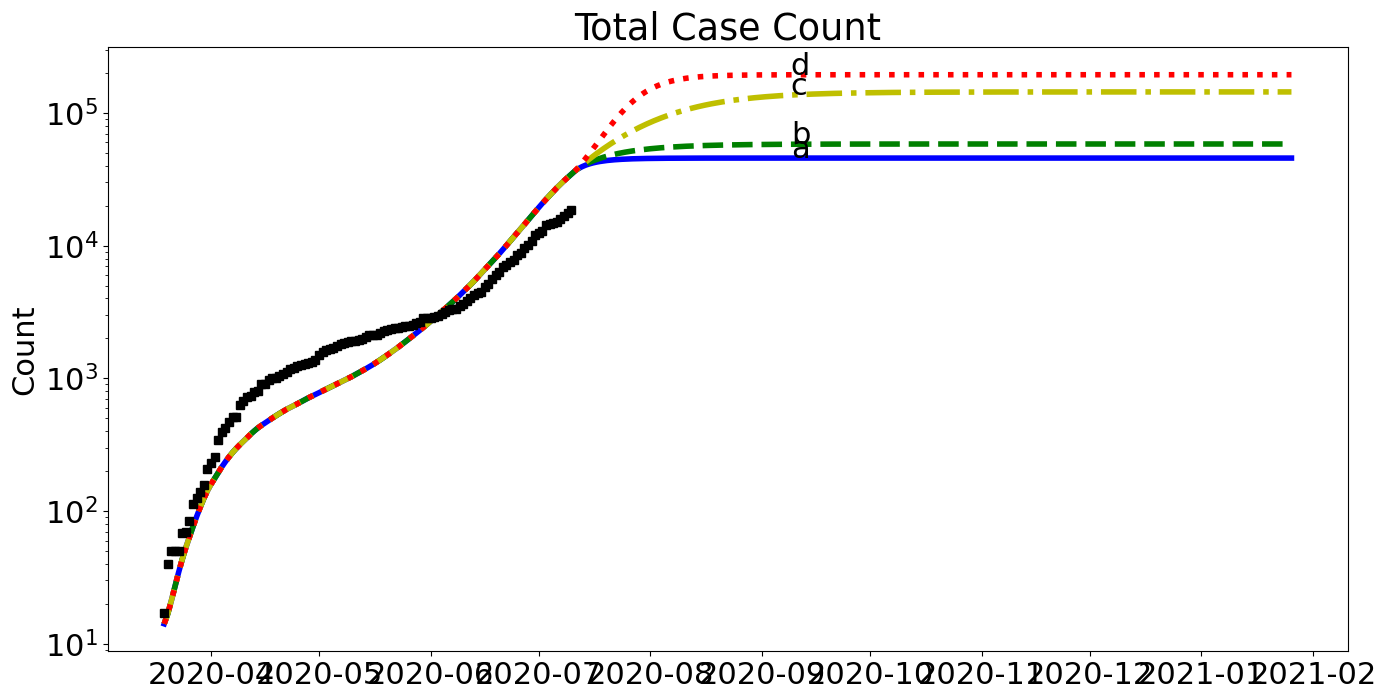

In [24]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch
import datetime as dt

############### Paths ##############################
####################################################

ROOT_DIR = os.path.join(os.path.dirname('/content/Livid-About-COVID/scripts'), '..')
sys.path.append(ROOT_DIR)

WEIGHTS_DIR = os.path.join(ROOT_DIR, 'model_weights')
if not os.path.exists(WEIGHTS_DIR):
    os.mkdir(WEIGHTS_DIR)

RESULTS_DIR = os.path.join(ROOT_DIR, 'Prediction_results')
if not os.path.exists(RESULTS_DIR):
    os.mkdir(RESULTS_DIR)

# from SIRNet import util, trainer
# from scripts import retrieve_data

########### ASSUMPTIONS ##############################
######################################################
reporting_rate = 0.1     # Portion of cases that are actually detected
delay_days = 10          # Days between becoming infected / positive confirmation (due to incubation period / testing latency
start_model = 23         # The day where we begin our fit

############## Simplified Data ####################
###################################################
paramdict = {}
paramdict['country'] = 'United States'
paramdict['states'] = ['Texas']
paramdict['counties'] = ['Bexar County']
df = get_data(paramdict)

mobility = df[['Retail & recreation', 'Grocery & pharmacy', 'Parks',
               'Transit stations', 'Workplace', 'Residential']]
cases = df['Cases']
day0 = df['date'][0]
population = df['Population'][0]

# offset case data by delay days (treat it as though it was recorded earlier)
cases = np.array(cases[delay_days:])
mobility = np.array(mobility[:-delay_days])
county_name = 'Bexar'

###################### Formatting Data ######################
#############################################################
mobility = np.asarray(mobility, dtype=np.float32)
# convert percentages of change to fractions of activity
mobility[:, :6] = (1.0 + mobility[:, :6] / 100.0)

# Initial conditions
i0 = float(cases[start_model-1]) / population / reporting_rate
e0 = 2.2*i0/5.0
mobility = mobility[start_model:]  # start with delay
cases = cases[start_model:]        # delay days

# Split into input and output data
X, Y = mobility, cases

# divide out population of county, reporting rate
Y = (Y / population) / reporting_rate

# To Torch on device
X = torch.from_numpy(X.astype(np.float32))
Y = torch.from_numpy(Y.astype(np.float32))

# Add batch dimension
X = X.reshape(X.shape[0], 1, X.shape[1])  # time x batch x channels
Y = Y.reshape(Y.shape[0], 1, 1)  # time x batch x channels

#################### Training #######################
#####################################################
weights_name = WEIGHTS_DIR + '/{}_weights.pt'.format(county_name)
trainer = Trainer(weights_name)
model = trainer.build_model(e0, i0)
# 300 epochs
trainer.train(model, X, Y, 50)

################ Forecasting #######################
####################################################
active = {}
total = {}
cases = [25, 50, 75, 100]
for case in cases:
    xN = torch.ones((1, 6), dtype=torch.float32) * case/100
    rX = xN.expand(200, *xN.shape)  # 200 x 1 x 6
    rX = torch.cat((X, rX), dim=0)
    sir_state, total_cases = model(rX)
    s = to_numpy(sir_state)
    active[case] = s[:, 0] * reporting_rate * population
    total[case] = (s[:, 0] + s[:, 1]) * reporting_rate * population

############## Forecast Dates ####################
##################################################
yy, mm, dd = day0.split('-')
date0 = dt.datetime(int(yy), int(mm), int(dd))
days = np.arange(rX.shape[0])
dates = [date0 + dt.timedelta(days=int(d + delay_days + start_model))
         for d in days]

############### Reporting #########################
###################################################
print('\n#########################################\n\n')
timestamp = dt.datetime.now().strftime('%Y_%m_%d')
for case in cases:
    M = np.max(active[case])
    idx = np.argmax(active[case])
    print('Case: {}%'.format(case))
    print('  Max value: {}'.format(M))
    print('  Day: {}, {}'.format(idx, dates[idx]))

############### Plotting ##########################
###################################################
gt = np.squeeze(Y.numpy()) * reporting_rate * population

# plot styles & plot letters
cs = {25: 'b-', 50: 'g--', 75: 'y-.', 100: 'r:'}
cl = {25: 'a', 50: 'b', 75: 'c', 100: 'd'}

# Default text size
plt.rcParams.update({'font.size': 22})

# Plot 1. Total Cases (Log)
plt.figure(dpi=100, figsize=(16, 8))
pidx = gt.shape[0] + 60  # write letter prediction at 60 days in the future
for case in total.keys():
    plt.plot(dates, total[case], cs[case], linewidth=4.0,
             label='{}. {}% Mobility'.format(cl[case], case))
    plt.text(dates[pidx], total[case][pidx], cl[case])
plt.plot(dates[:Y.shape[0]], gt, 'ks', label='SAMHD Data')

plt.title('Total Case Count')
plt.ylabel('Count')
plt.yscale('log')
plt_setup()
plt.savefig(RESULTS_DIR + '/{}_Total_Cases.pdf'.format(timestamp))
plt.show()

# Plots 2 & 3. Active Cases (zoomed out and zoomed in)
for zoom in [True, False]:
    plt.figure(dpi=100, figsize=(16, 8))
    for case in total.keys():
        plt.plot(dates, active[case], cs[case], linewidth=4.0,
                 label='{}. {}% Mobility'.format(cl[case], case))
        pidx = (gt.shape[0] + 10 if zoom else
                np.argmax(active[case]))  # write at 10 days or peak
        plt.text(dates[pidx], active[case][pidx], cl[case])

    plt.title('Active (Infectious) Case Count')
    plt.ylabel('Count')
    if zoom:
        plt.ylim((0, gt[-1]))
    plt_setup()
    plt.savefig(RESULTS_DIR + '/{}_Active_Cases{}.pdf'.format(timestamp, zoom))
    plt.show()


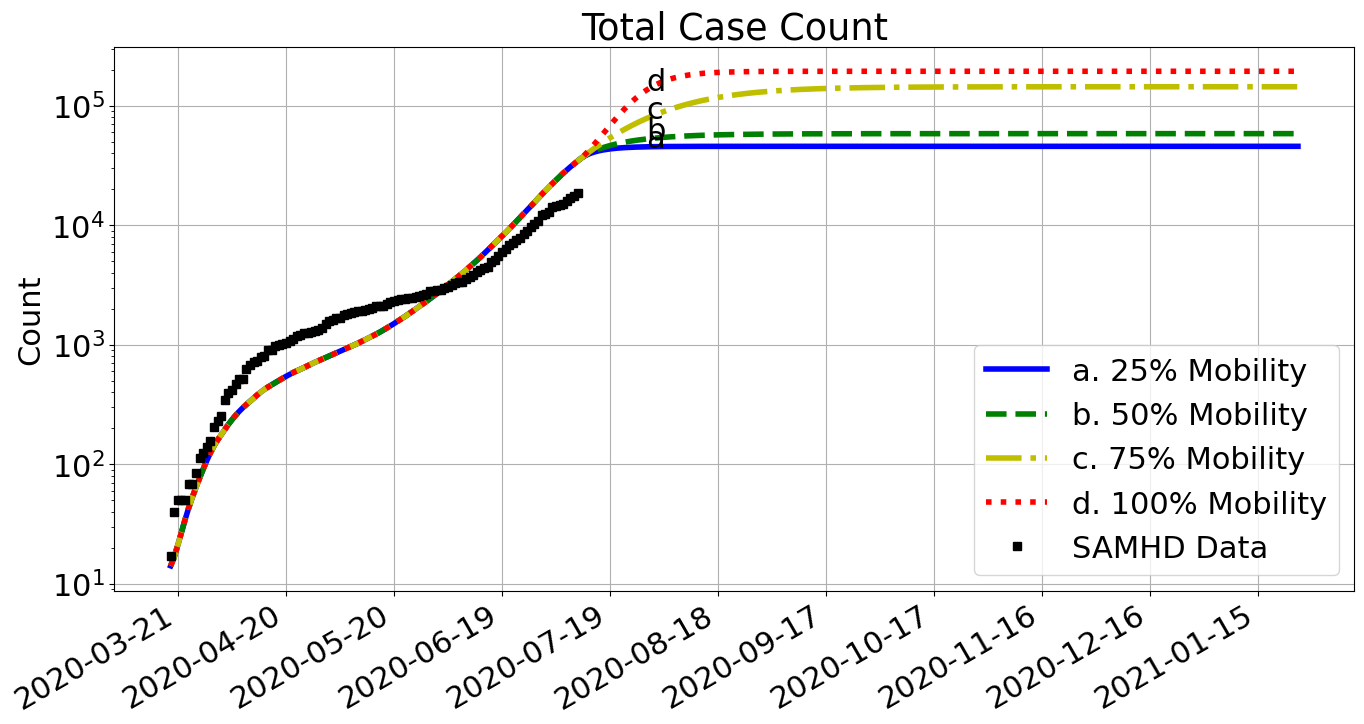

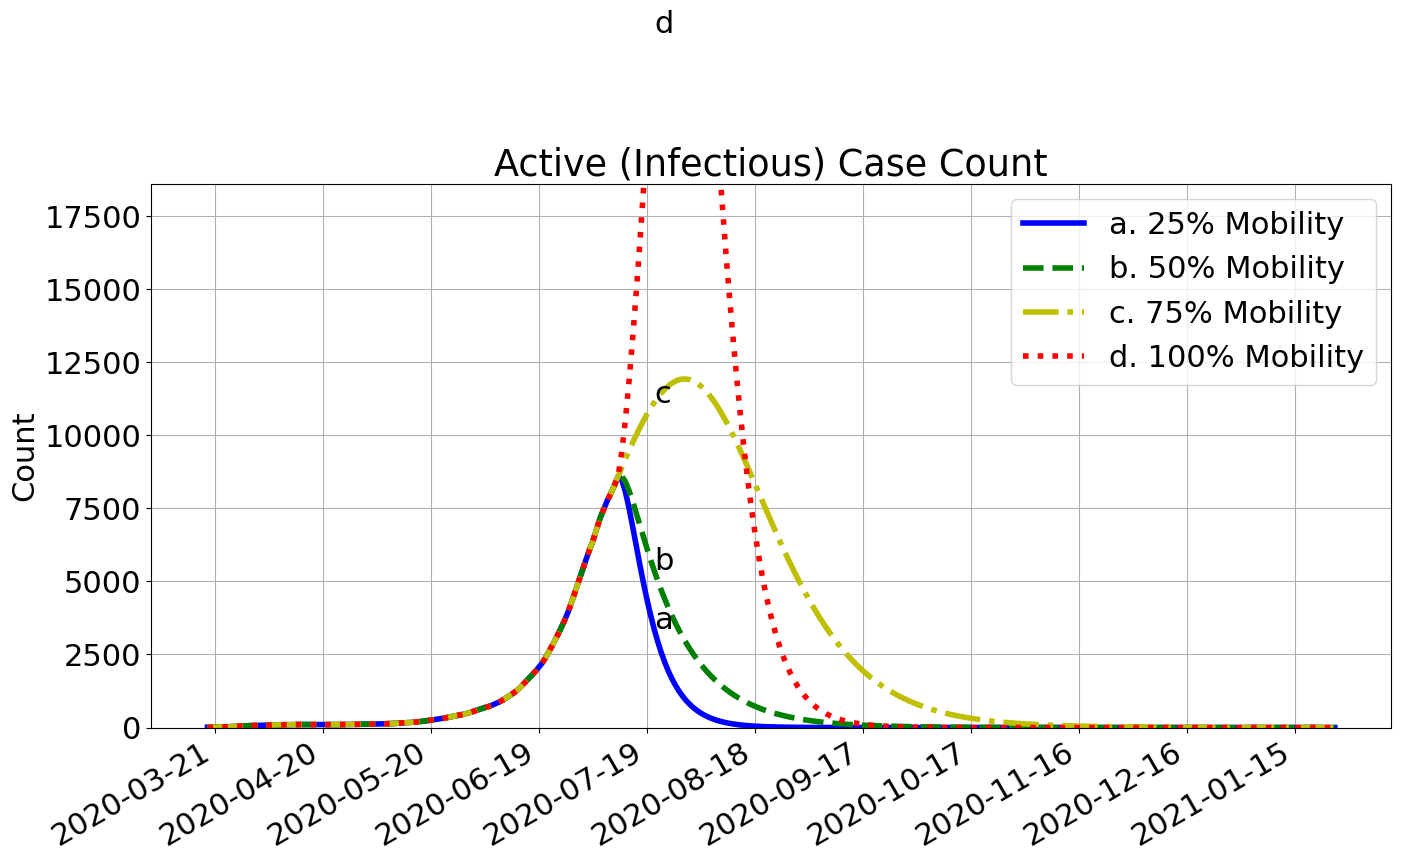

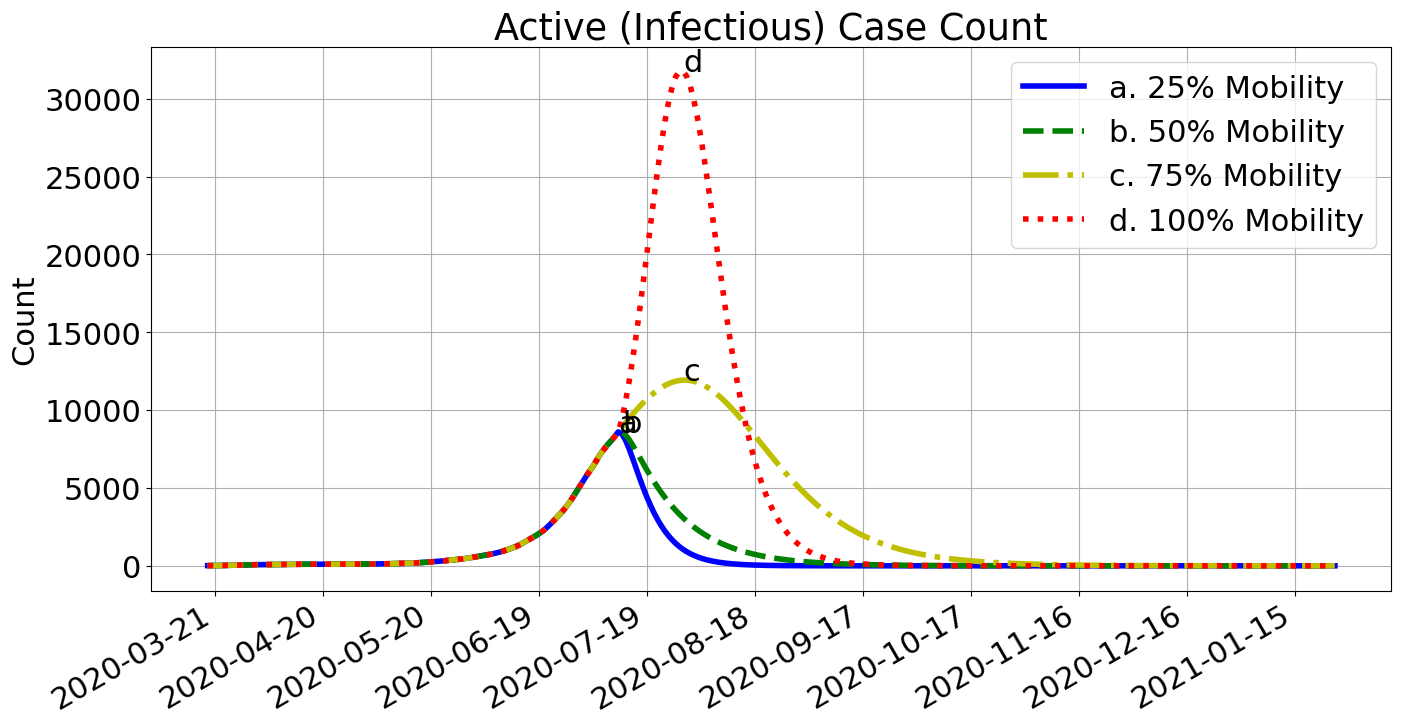

In [27]:
plt.figure(dpi=100, figsize=(16, 8))
for case in total.keys():
    plt.plot(dates, total[case], cs[case], linewidth=4.0,
             label='{}. {}% Mobility'.format(cl[case], case))
    plt.text(dates[pidx], total[case][pidx], cl[case])
plt.plot(dates[:Y.shape[0]], gt, 'ks', label='SAMHD Data')

plt.title('Total Case Count')
plt.ylabel('Count')
plt.yscale('log')
plt_setup()
plt.savefig(RESULTS_DIR + '/{}_Total_Cases.pdf'.format(timestamp))
plt.show()

# Plots 2 & 3. Active Cases (zoomed out and zoomed in)
for zoom in [True, False]:
    plt.figure(dpi=100, figsize=(16, 8))
    for case in total.keys():
        plt.plot(dates, active[case], cs[case], linewidth=4.0,
                 label='{}. {}% Mobility'.format(cl[case], case))
        pidx = (gt.shape[0] + 10 if zoom else
                np.argmax(active[case]))  # write at 10 days or peak
        plt.text(dates[pidx], active[case][pidx], cl[case])

    plt.title('Active (Infectious) Case Count')
    plt.ylabel('Count')
    if zoom:
        plt.ylim((0, gt[-1]))
    plt_setup()
    plt.savefig(RESULTS_DIR + '/{}_Active_Cases{}.pdf'.format(timestamp, zoom))
    plt.show()
